In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from wave_prop_module import Wave2d
from torch import optim

In [2]:
X, Y = np.meshgrid(np.linspace(1, 1024, 1024), np.linspace(1, 1360, 1360))

A = np.array([X.T.ravel(), Y.T.ravel(), X.T.ravel()*Y.T.ravel(), X.T.ravel()*X.T.ravel(), Y.T.ravel()*Y.T.ravel(), np.ones_like(X.T.ravel()), 
              (X.T.ravel())**3, (Y.T.ravel())**3, X.T.ravel()*(Y.T.ravel())**2, Y.T.ravel()*(X.T.ravel())**2], dtype=np.float64).T

a = np.array([ 1.17655156e-02, -1.51491607e-01, -6.56743097e-05, -2.37207694e-05,
              1.22171882e-06, -2.49903795e+00,  1.76049918e-08,  4.34031215e-09,
              6.71527369e-09,  1.97710590e-08])

lin_phase = (A@a).reshape(1024, 1360)

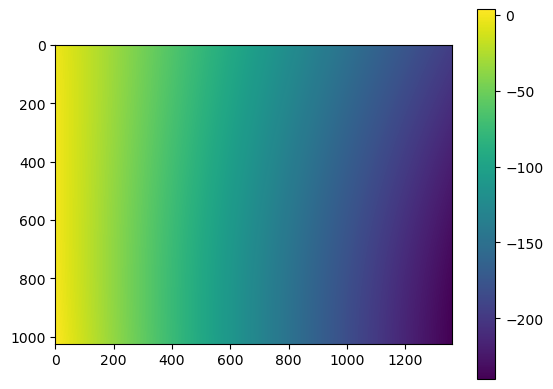

In [3]:
plt.imshow(lin_phase)
plt.colorbar()

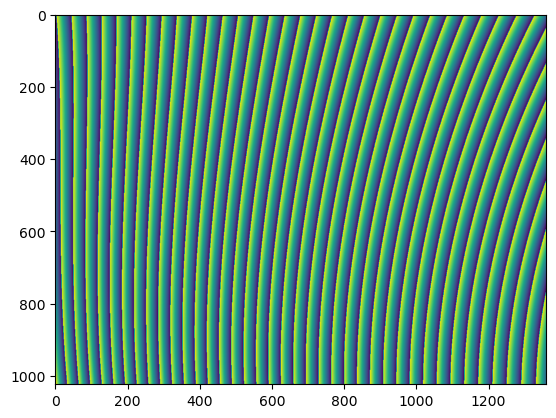

In [4]:
# wave vector
wave = torch.exp(1j*torch.tensor(lin_phase))
plt.imshow(wave.angle())

In [5]:
# create object tensor

obj_amp = torch.rand(1024, 1360)
obj_phase = torch.rand(1024, 1360)

obj = obj_amp*torch.exp(1j*obj_phase)

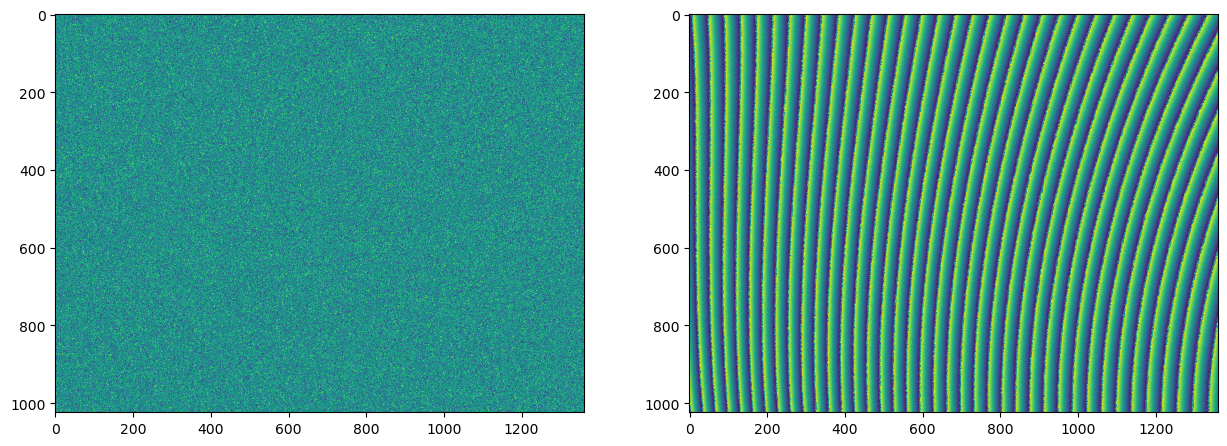

In [6]:
wave_op = wave*obj

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].imshow(torch.abs(wave_op))
axs[1].imshow(torch.angle(wave_op))

plt.show()

/home/kazim/anaconda3/envs/Phase_Unwrap_DIP/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608843393/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


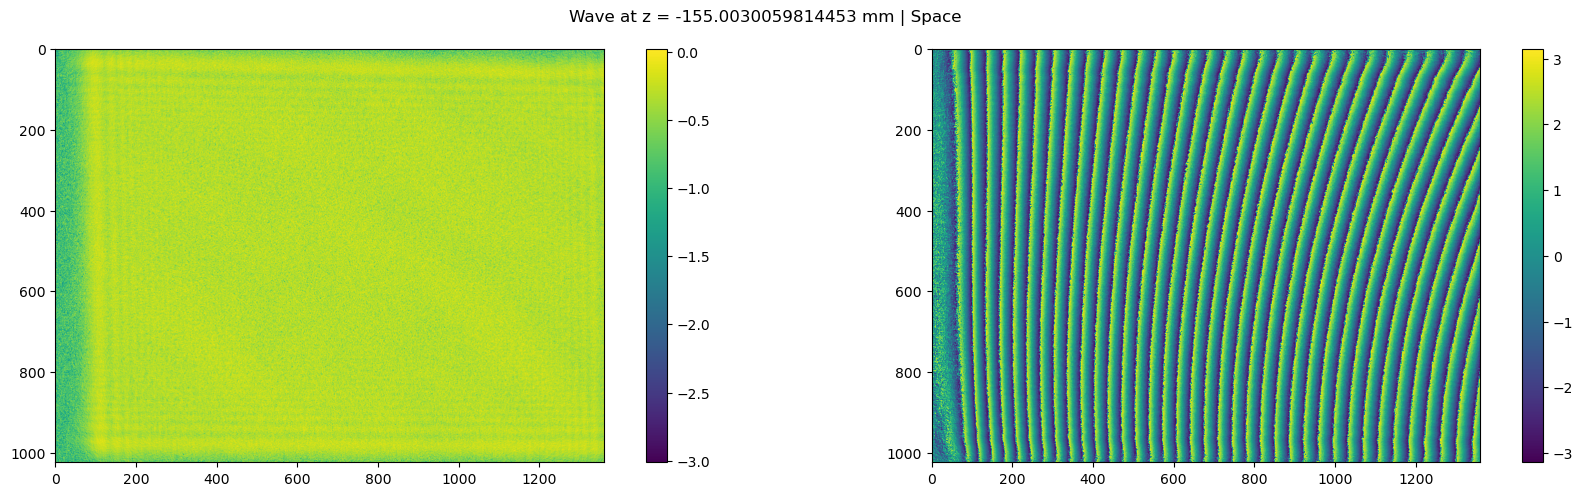

/tmp/ipykernel_1618270/3761141959.py:26: RuntimeWarning: divide by zero encountered in log10
  cp_amp = axs[0].imshow(np.log10(np.abs((wave_obj.fft_wave_z1))).T)


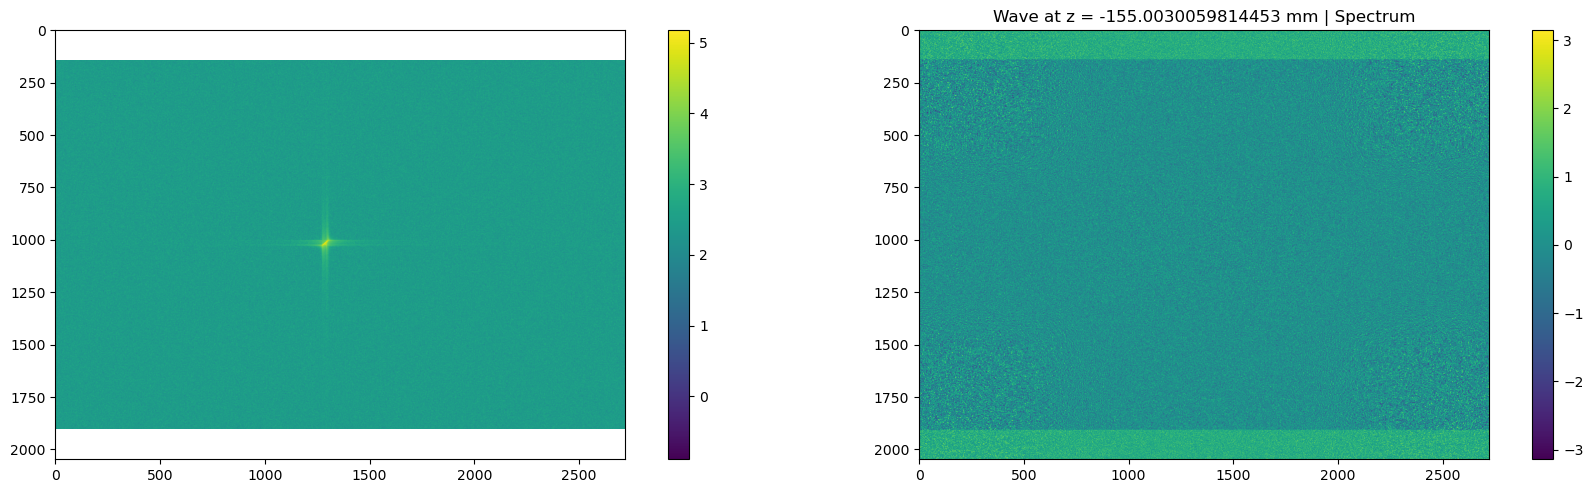

In [7]:
# propagation model

wave_obj = Wave2d(
    numPx = list(wave_op.shape), 
    sizePx = [6*1e-3, 6*1e-3], 
    wl = 550*1e-6
    )

wave_obj.wavefield(wave_op.T)

dist = torch.tensor(-155.003) # mm

wave_z = wave_obj.propogate(dist)

fig, axs = plt.subplots(1, 2, figsize=(18, 5), tight_layout=True)

cp_amp = axs[0].imshow(np.log10(np.abs(wave_z)).T)
cp_ang = axs[1].imshow(((np.angle(wave_z))).T,  )

fig.colorbar(cp_amp, ax=axs[0])
fig.colorbar(cp_ang, ax=axs[1])
fig.suptitle(f'Wave at z = {dist} mm | Space')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5), tight_layout=True)
cp_amp = axs[0].imshow(np.log10(np.abs((wave_obj.fft_wave_z1))).T)

cp_ang = axs[1].imshow(np.angle(wave_obj.fft_wave_z1).T, )
fig.colorbar(cp_amp, ax=axs[0])
fig.colorbar(cp_ang, ax=axs[1])
plt.title(f'Wave at z = {dist} mm | Spectrum')
plt.show()

In [69]:
# loss function

def grad_optr(image):

    dx = image.squeeze() - F.pad(image.squeeze(), (0, 1, 0, 0))[:, 1:]
    dy = image.squeeze() - F.pad(image.squeeze(), (0, 0, 0, 1))[1:, :]

    dx[:, -1] = 0
    dy[-1, :] = 0

    return dx, dy

def wrap(vector):
    return torch.remainder(vector + torch.pi, 2*torch.pi)

def loss_fn(predict, target):
    
    del_pred_x, del_pred_y = grad_optr(predict)
    del_tar_x, del_tar_y = grad_optr(target)

    dx_dy_pred = torch.concat([wrap(del_pred_x).ravel().unsqueeze(dim=1), wrap(del_pred_y).ravel().unsqueeze(dim=1)], dim=1)
    dx_dy_tar_wrap = torch.concat([wrap(del_tar_x).ravel().unsqueeze(dim=1), wrap(del_tar_y).ravel().unsqueeze(dim=1)], dim=1)

    norm = torch.linalg.norm(dx_dy_pred- dx_dy_tar_wrap, dim=1)
    loss = torch.sum(norm)


    return loss

In [70]:
# complete model
device = torch.device('cuda:0')

wave_phase = torch.tensor(lin_phase, requires_grad=True)
wave = torch.exp(1j*wave_phase)

# obj_amp = torch.rand(1024, 1360, requires_grad=True)
obj_phase = torch.rand(1024, 1360, requires_grad=True)

phase_img = np.load('phase_0.npy')
target = torch.tensor(phase_img).T

optimizer = optim.Adam(
    [obj_phase],
    lr=0.01, betas=(0.9, 0.999))

wave_obj = Wave2d(
        numPx = list(wave.shape), 
        sizePx = [6*1e-3, 6*1e-3], 
        wl = 550*1e-6
        )

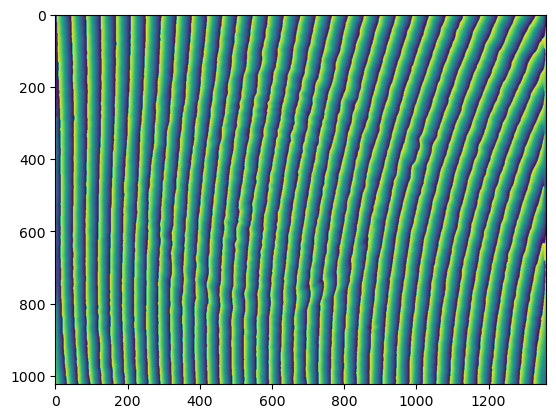

In [133]:
plt.imshow(target.T)

In [71]:
epochs = 10000
loss_arr = []


for itr in range(epochs):

    optimizer.zero_grad()

    obj = torch.exp(1j*obj_phase)
    wave_op = wave.detach()*obj
    wave_obj.wavefield(wave_op.T)
    dist = torch.tensor(155.003) # mm 
    wave_z = torch.angle(wave_obj.propogate(dist))
    loss = loss_fn(wave_z, target)
    loss.backward()
    optimizer.step()
    loss_arr.append(loss.item())

    print(itr, loss_arr[-1])

0 237167.28336306848
1 224243.63910165327
2 212799.07791795107
3 202297.3163017689
4 192732.82443632308
5 183837.93224805157
6 175558.94683608226
7 167752.65398774063
8 160330.8568085026
9 153219.18200577382
10 146374.12311619008
11 139803.65696135748
12 133464.19129646732
13 127348.96915795075
14 121449.92325322275
15 115769.35739953429
16 110310.70235874693
17 105073.18329859339
18 100051.01814474177
19 95272.93108003304
20 90733.54606387315
21 86428.56202627734
22 82355.2433503127
23 78516.43905300427
24 74904.78087743836
25 71505.748270609
26 68322.68651085567
27 65347.32616115066
28 62579.62432806599
29 60011.24862711219
30 57633.31633028364
31 55449.204995714535
32 53459.01542581829
33 51649.259176138585
34 50008.98410968559
35 48524.329192906276
36 47183.121565980604
37 45970.857380479414
38 44873.99360600838
39 43880.88900563265
40 42976.21763902099
41 42145.56540342106
42 41380.401216678394
43 40668.98774032823
44 40005.17387241743
45 39376.5217109981
46 38777.76396362893
47 3

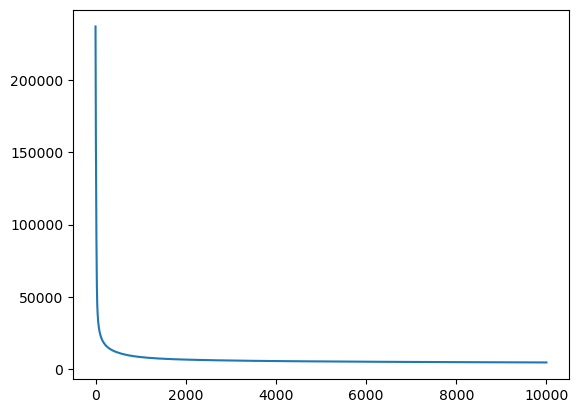

In [72]:
plt.plot(loss_arr)

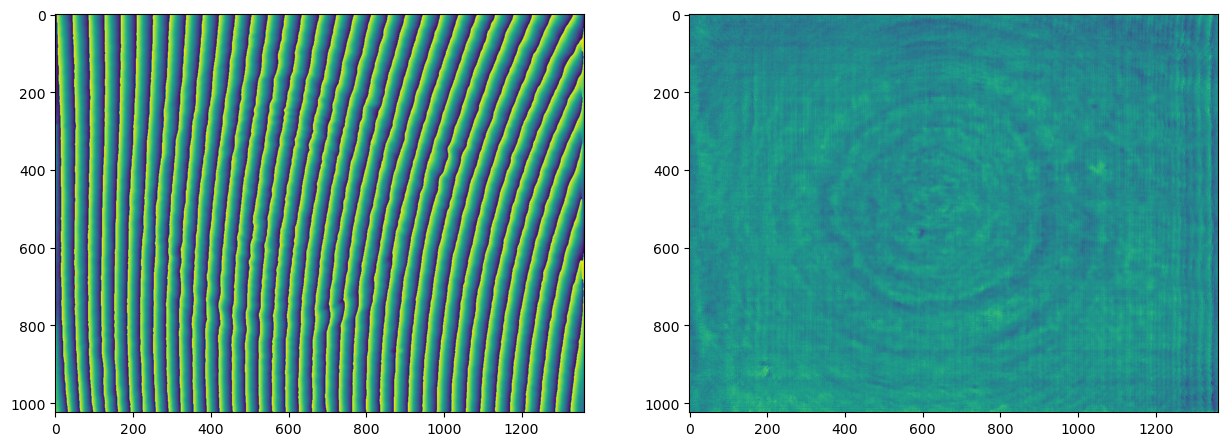

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[1].imshow(obj_phase.detach())
axs[0].imshow(target.T)


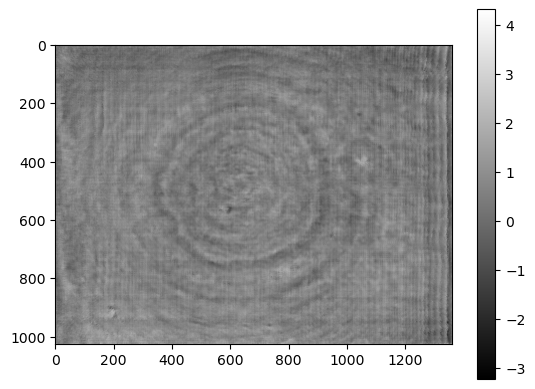

In [ ]:
plt.imshow((obj_phase.detach().numpy()), cmap='gray')
plt.colorbar()

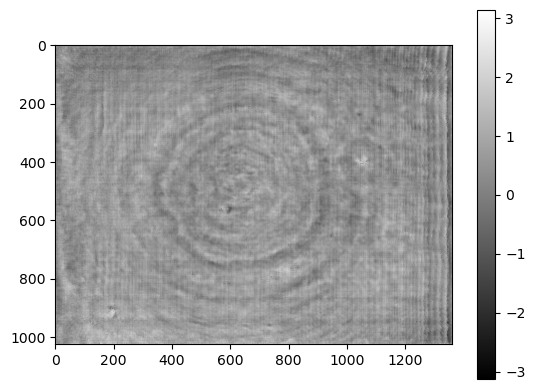

In [131]:
plt.imshow((torch.angle(obj).detach().numpy()), cmap='gray')
plt.colorbar()

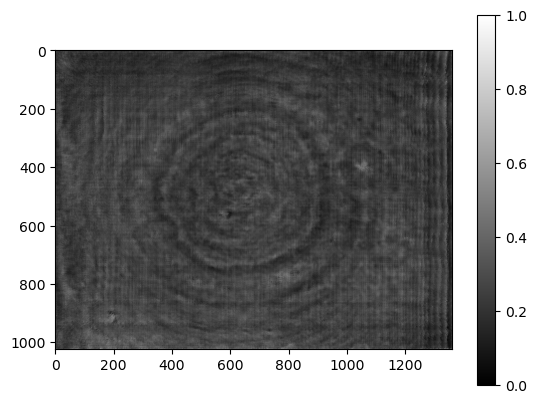

In [130]:
rec_ph = obj_phase.detach().numpy()
rec_ph = (rec_ph - rec_ph.min())/(rec_ph.max() - rec_ph.min())

plt.imshow(rec_ph**2, cmap='gray')
plt.colorbar()